In [152]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import keras.backend as K
from tensorflow import keras
from keras.layers import Reshape, Conv2DTranspose, PReLU
from keras.utils import to_categorical, plot_model
from keras.layers import Concatenate
import numpy as np
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.image import resize
from scipy.linalg import sqrtm
import math
import tensorflow as tf
from IPython.display import clear_output, HTML
import glob
from keras.layers import AveragePooling2D, ZeroPadding2D, BatchNormalization, Activation, MaxPool2D, Add
from keras.layers import Normalization, Dense, Conv2D, Dropout, BatchNormalization, ReLU
from keras.models import Sequential, Model
from keras import Input
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.initializers import RandomNormal
from keras.layers import LeakyReLU, GlobalMaxPooling2D, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
import numpy as np
from skimage.transform import AffineTransform, warp
from keras import Sequential, Model
from keras.layers import Dense, Conv2D, Reshape, UpSampling2D, \
    BatchNormalization, Activation, Input, LeakyReLU, ZeroPadding2D, Dropout, Flatten, Conv2DTranspose
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import os

In [153]:
sns.set(style='darkgrid', palette='deep')

In [154]:
# List physical GPUs and set memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [155]:
# Read the CSV file into a pandas DataFrame
df = pd.read_csv('emnist-letters-train.csv', delimiter=',', header=None)

In [156]:
df.rename(columns={0: 'labels'}, inplace=True)

In [157]:
df = df[df['labels'] != -1]


In [158]:
# Convert the DataFrame to a NumPy array
data = df.to_numpy()

# Extract the labels and images from the NumPy array
labels = data[:, 0]  # Assuming the first column is the labels
images = data[:, 1:]  # The rest are the images

# Optionally, you can reshape and normalize the images if needed
# For example, if the images are 28x28 pixels
images = images.reshape(-1, 28, 28, 1)  # Reshape to (num_samples, 28, 28, 1)
images = images / 255.0  # Normalize to [0, 1]

# Define the mapping dictionary
mapping = {-1: 63, 1: 97, 2: 98, 3: 99, 4: 100, 5: 101, 6: 102, 7: 103, 8: 104, 9: 105, 
           10: 106, 11: 107, 12: 108, 13: 109, 14: 110, 15: 111, 16: 112, 17: 113, 
           18: 114, 19: 115, 20: 116, 21: 117, 22: 118, 23: 119, 24: 120, 25: 121, 
           26: 122, 27: 123}

# Re-map the labels using the mapping dictionary
mapped_labels = np.vectorize(mapping.get)(labels)

# Convert the mapped labels to characters
labels = np.vectorize(chr)(mapped_labels)

# Now 'images' and 'labels' are NumPy arrays ready for use
print(images.shape)
print(labels.shape)


(88800, 28, 28, 1)
(88800,)


In [159]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)



In [160]:
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (56832, 28, 28, 1)
Validation set shape: (14208, 28, 28, 1)
Test set shape: (17760, 28, 28, 1)


In [161]:
unique_labels = np.unique(y_train)

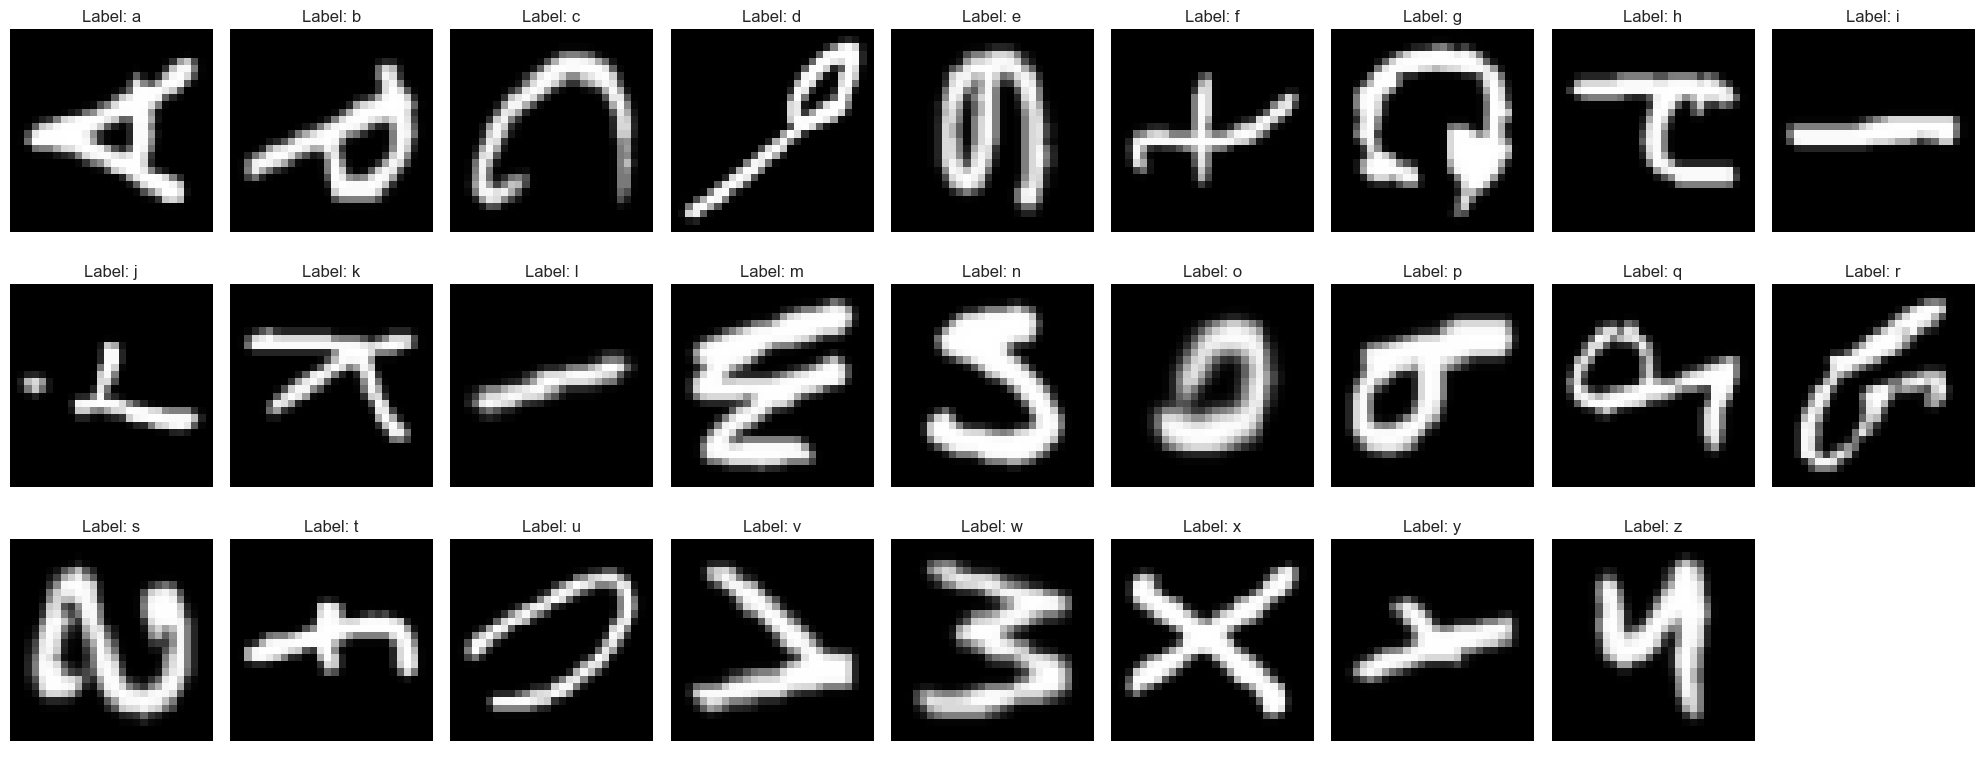

In [162]:
# Create the plot with sufficient subplots
fig, axes = plt.subplots(3, 9, figsize=(20, 8))  # Adjusted to 3 rows and 9 columns for demonstration
axes = axes.flatten()

for label, ax in zip(unique_labels, axes):
    # Select the first image for each unique label
    idx = np.where(y_train == label)[0][0]
    image = X_train[idx].reshape(28, 28)
    
    # Display the image
    ax.imshow(image, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')

# Hide any remaining empty subplots (if any)
for ax in axes[len(unique_labels):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

<hr>
<h3>Viewing Augmented vs Actual</h3>
    <h4><li>Rotate</li>
    <li>Shear</li>
    <li>Flip</li></h4>
<hr>

In [163]:
def plot_images_per_label_Aug_sheer(images, labels, num_images_per_label=5):
    unique_labels = np.unique(labels)
    
    # Create the plot with sufficient subplots
    fig, axes = plt.subplots(len(unique_labels), num_images_per_label * 2, figsize=(20, len(unique_labels) * 2))
    axes = axes.flatten()  # Flatten the 2D array of axes to easily iterate

    # Counter for current axis
    ax_index = 0

    for label in unique_labels:
        # Filter images for the current label
        indices = np.where(labels == label)[0]
        
        # Loop through up to num_images_per_label images for the current label
        for i in range(min(num_images_per_label, len(indices))):
            image = images[indices[i]].reshape(28, 28)
            
            # Display the original image
            axes[ax_index].imshow(image, cmap='gray')
            axes[ax_index].set_title(f'Label: {label}')
            axes[ax_index].axis('off')
            ax_index += 1

            if ax_index >= len(axes):
                break

        for i in range(min(num_images_per_label, len(indices))):
            image = images[indices[i]].reshape(28, 28)

            # Rotate the image by 15 degrees
            rotated_image = rotate(image, -90, reshape=False)
            
            # Apply shear transformation
            shear_transform = AffineTransform(shear=0.2)
            sheared_image = warp(rotated_image, shear_transform.inverse, mode='wrap')
            flipped_image = np.fliplr(sheared_image)

            # Display the augmented image
            axes[ax_index].imshow(flipped_image, cmap='gray')
            axes[ax_index].set_title(f'Labels Augmented: {label}')
            axes[ax_index].axis('off')
            ax_index += 1

            if ax_index >= len(axes):
                break

    # Hide any remaining empty subplots (if any)
    for ax in axes[ax_index:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [164]:
# plot_images_per_label_Aug_sheer(X_train, y_train)

In [171]:
class DCGAN():
    
    # this is the function to build the generator neural network
    def build_generator(self):
        model = Sequential(name='Generator')
        model.add(Dense(128 * 7 * 7, activation="relu", input_dim=self.latent_dim)) # connect the input to dense layer
        model.add(Reshape((7, 7, 128)))
        # upsample from 7*7 to 14*14
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        # upsample to 28x28
        model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Conv2D(self.channels, kernel_size=7, padding="same", activation='sigmoid'))
        model.summary()
        noise = Input(shape=(self.latent_dim,))
        img = model(noise)
        return Model(noise, img)  # the keras Model class groups layers into an object with training and inference features
    
    def build_discriminator(self):
        model = Sequential(name='Discriminator')
        model.add(Conv2D(128, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dense(27, activation='sigmoid'))
        model.summary()
        img = Input(shape=self.img_shape)
        validity = model(img)
        return Model(img, validity)

    def __init__(self, rows, cols, channels, z = 100):
        # Input shape
        self.img_rows = rows  # generated image height
        self.img_cols = cols  # generated image width
        self.channels = channels  # generated image channel
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = z  # the input is 1-D vector of noise
        # Reduce learning rate from 0.001 to 0.0002, and beta1 from 0.9 to 0.5, which can stablize training and reduce oscillation
        optimizer = Adam(learning_rate=0.0002, beta_1=0.5)
        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])
        # Build the generator
        self.generator = self.build_generator()
        # The generator takes noise as input and generates images
        z = Input(shape=(self.latent_dim,))
        img = self.generator(z)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False
        # The discriminator takes generated images as input and determines validity
        valid = self.discriminator(img)
        # The combined model (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy',
            optimizer=optimizer)
    
    def train(self, epochs, batch_size=128, save_interval=50):
        # Split the data into train and test sets
        X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)
        # Rescale 0 to 1
        X_train = X_train / 255
        X_train = np.expand_dims(X_train, axis=3)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        for epoch in range(epochs):

            # Select a random half of images
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            imgs = X_train[idx]
            # Sample noise and generate a batch of new images
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_imgs = self.generator.predict(noise)
            # Train the discriminator (it classify real images as 1 and generated images as 0)
            d_loss_real = self.discriminator.train_on_batch(imgs, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            # Train the generator (it wants discriminator to predict generated images as 1)
            g_loss = self.combined.train_on_batch(noise, valid)
            # Plot the progress
            print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
            
            # If at save interval => save generated image samples
            if epoch % save_interval == 0:
                self.save_imgs(epoch)
    
    def save_imgs(self, epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        os.makedirs('generated_mnist', exist_ok=True)
        fig.savefig("generated_mnist/dcgan_mnist_improved_{:d}.png".format(epoch))
        plt.close()

In [172]:
dcgan = DCGAN(28,28,1)
dcgan.train(epochs=5000, batch_size=256, save_interval=50)

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 14, 14, 128)       1280      
                                                                 
 leaky_re_lu_24 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                                 
 dropout_12 (Dropout)        (None, 14, 14, 128)       0         
                                                                 
 conv2d_19 (Conv2D)          (None, 7, 7, 128)         147584    
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_13 (Dropout)        (None, 7, 7, 128)         0         
                                                                 
 flatten_6 (Flatten)         (None, 6272)            

ValueError: in user code:

    File "c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "c:\Users\user\anaconda3\envs\gpu_env\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((256, 27) vs (256, 1)).
